In [1]:
import torch
import pickle
import numpy as np 
import glob
import re
import os
import matplotlib.pyplot as plt
import scipy, sklearn
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import io
import mne
import pandas as pd
import time
os.chdir('/external/rprshnas01/netdata_kcni/jglab/Data/Davide/reproduce_Momi_et_al_2022/PyTepFit/tepfit/')
from fit import ParamsJR, Model_fitting, RNNJANSEN, Costs, OutputNM

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Pytorch stuff


"""
Importage
"""

#from Model_pytorch import wwd_model_pytorch_new
import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import seaborn as sns # for plotting 
import time # for timer
import torch
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import pickle

from torch.nn.parameter import Parameter

class OutputNM():
    mode_all = ['train', 'test']
    stat_vars_all = ['m', 'v']

    def __init__(self, model_name, node_size, param, fit_weights=False, fit_lfm=False):
        self.loss = np.array([])
        if model_name == 'WWD':
            state_names = ['E', 'I', 'x', 'f', 'v', 'q']
            self.output_name = "bold"
        elif model_name == "JR":
            state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
            self.output_name = "eeg"
        for name in state_names + [self.output_name]:
            for m in self.mode_all:
                setattr(self, name + '_' + m, [])

        vars = [a for a in dir(param) if not a.startswith('__') and not callable(getattr(param, a))]
        for var in vars:
            if np.any(getattr(param, var)[1] > 0):
                if var != 'std_in':
                    setattr(self, var, np.array([]))
                    for stat_var in self.stat_vars_all:
                        setattr(self, var + '_' + stat_var, [])
                else:
                    setattr(self, var, [])
        
        self.weights = []
        if model_name == 'JR' and fit_lfm == True:
            self.leadfield = []

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)


class ParamsJR():

    def __init__(self, model_name, **kwargs):
        if model_name == 'WWD':
            param = {

                "std_in": [0.02, 0],  # standard deviation of the Gaussian noise
                "std_out": [0.02, 0],  # standard deviation of the Gaussian noise
                # Parameters for the ODEs
                # Excitatory population
                "W_E": [1., 0],  # scale of the external input
                "tau_E": [100., 0],  # decay time
                "gamma_E": [0.641 / 1000., 0],  # other dynamic parameter (?)

                # Inhibitory population
                "W_I": [0.7, 0],  # scale of the external input
                "tau_I": [10., 0],  # decay time
                "gamma_I": [1. / 1000., 0],  # other dynamic parameter (?)

                # External input
                "I_0": [0.32, 0],  # external input
                "I_external": [0., 0],  # external stimulation

                # Coupling parameters
                "g": [20., 0],  # global coupling (from all nodes E_j to single node E_i)
                "g_EE": [.1, 0],  # local self excitatory feedback (from E_i to E_i)
                "g_IE": [.1, 0],  # local inhibitory coupling (from I_i to E_i)
                "g_EI": [0.1, 0],  # local excitatory coupling (from E_i to I_i)

                "aE": [310, 0],
                "bE": [125, 0],
                "dE": [0.16, 0],
                "aI": [615, 0],
                "bI": [177, 0],
                "dI": [0.087, 0],

                # Output (BOLD signal)

                "alpha": [0.32, 0],
                "rho": [0.34, 0],
                "k1": [2.38, 0],
                "k2": [2.0, 0],
                "k3": [0.48, 0],  # adjust this number from 0.48 for BOLD fluctruate around zero
                "V": [.02, 0],
                "E0": [0.34, 0],
                "tau_s": [0.65, 0],
                "tau_f": [0.41, 0],
                "tau_0": [0.98, 0],
                "mu": [0.5, 0]

            }
        elif model_name == "JR":
            param = {
                "A ": [3.25, 0], "a": [100, 0.], "B": [22, 0], "b": [50, 0], "g": [1000, 0], \
                "c1": [135, 0.], "c2": [135 * 0.8, 0.], "c3 ": [135 * 0.25, 0.], "c4": [135 * 0.25, 0.], \
                "std_in": [100, 0], "vmax": [5, 0], "v0": [6, 0], "r": [0.56, 0], "y0": [2, 0], \
                "mu": [.5, 0], "k": [5, 0], "cy0": [5, 0], "ki": [1, 0]
            }
        for var in param:
            setattr(self, var, param[var])

        for var in kwargs:
            setattr(self, var, kwargs[var])
        """self.A = A # magnitude of second order system for populations E and P
        self.a = a # decay rate of the 2nd order system for population E and P
        self.B = B # magnitude of second order system for population I
        self.b = b # decay rate of the 2nd order system for population I
        self.g= g # global gain
        self.c1= c1# local gain from P to E (pre)
        self.c2= c2 # local gain from P to E (post)
        self.c3= c3 # local gain from P to I
        self.c4= c4 # local gain from P to I
        self.mu = mu
        self.y0 = y0
        self.std_in= std_in # local gain from P to I
        self.cy0 = cy0
        self.vmax = vmax
        self.v0 = v0
        self.r = r
        self.k = k"""
        
        
def sys2nd(A, a,  u, x, v):
    return A*a*u -2*a*v-a**2*x

def sigmoid(x, vmax, v0, r):
    return vmax/(1+torch.exp(r*(v0-x)))


class RNNJANSEN(torch.nn.Module):
    """
    A module for forward model (JansenRit) to simulate a batch of EEG signals
    Attibutes
    ---------
    state_size : int
        the number of states in the JansenRit model
    input_size : int
        the number of states with noise as input
    tr : float
        tr of image
    step_size: float
        Integration step for forward model
    hidden_size: int
        the number of step_size in a tr
    batch_size: int
        the number of EEG signals to simulate
    node_size: int
        the number of ROIs
    sc: float node_size x node_size array
        structural connectivity
    fit_gains: bool
        flag for fitting gains 1: fit 0: not fit
    g, c1, c2, c3,c4: tensor with gradient on
        model parameters to be fit
    w_bb: tensor with node_size x node_size (grad on depends on fit_gains)
        connection gains
    std_in std_out: tensor with gradient on
        std for state noise and output noise
    hyper parameters for prior distribution of model parameters
    Methods
    -------
    forward(input, noise_out, hx)
        forward model (JansenRit) for generating a number of EEG signals with current model parameters
    """
    state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
    model_name = "JR"

    def __init__(self, input_size: int, node_size: int,
                 batch_size: int, step_size: float, output_size: int, tr: float, sc: float, lm: float, dist: float,
                 fit_gains_flat: bool, \
                 fit_lfm_flat: bool, param: ParamsJR) -> None:
        """
        Parameters
        ----------
        state_size : int
        the number of states in the JansenRit model
        input_size : int
            the number of states with noise as input
        tr : float
            tr of image
        step_size: float
            Integration step for forward model
        hidden_size: int
            the number of step_size in a tr
        batch_size: int
            the number of EEG signals to simulate
        node_size: int
            the number of ROIs
        output_size: int
            the number of channels EEG
        sc: float node_size x node_size array
            structural connectivity
        fit_gains: bool
            flag for fitting gains 1: fit 0: not fit
        param from ParamJR
        """
        super(RNNJANSEN, self).__init__()
        self.state_size = 6  # 6 states WWD model
        self.input_size = input_size  # 1 or 2 or 3
        self.tr = tr  # tr ms (integration step 0.1 ms)
        self.step_size = torch.tensor(step_size, dtype=torch.float32)  # integration step 0.1 ms
        self.hidden_size = np.int(tr / step_size)
        self.batch_size = batch_size  # size of the batch used at each step
        self.node_size = node_size  # num of ROI
        self.output_size = output_size  # num of EEG channels
        self.sc = sc  # matrix node_size x node_size structure connectivity
        self.dist = torch.tensor(dist, dtype=torch.float32)
        self.fit_gains_flat = fit_gains_flat  # flag for fitting gains
        self.fit_lfm_flat = fit_lfm_flat
        self.param = param

        self.output_size = lm.shape[0]  # number of EEG channels

        # set model parameters (variables: need to calculate gradient) as Parameter others : tensor
        # set w_bb as Parameter if fit_gain is True
        if self.fit_gains_flat == True:
            self.w_bb = Parameter(torch.tensor(np.zeros((node_size, node_size)) + 0.05,
                                               dtype=torch.float32))  # connenction gain to modify empirical sc
        else:
            self.w_bb = torch.tensor(np.zeros((node_size, node_size)), dtype=torch.float32)

        if self.fit_lfm_flat == True:
            self.lm = Parameter(torch.tensor(lm, dtype=torch.float32))  # leadfield matrix from sourced data to eeg
        else:
            self.lm = torch.tensor(lm, dtype=torch.float32)  # leadfield matrix from sourced data to eeg

        vars = [a for a in dir(param) if not a.startswith('__') and not callable(getattr(param, a))]
        for var in vars:
            if np.any(getattr(param, var)[1] > 0):
                setattr(self, var, Parameter(
                    torch.tensor(getattr(param, var)[0] + 1 / getattr(param, var)[1] * np.random.randn(1, )[0],
                                 dtype=torch.float32)))
                if var != 'std_in':
                    dict_nv = {}
                    dict_nv['m'] = getattr(param, var)[0]
                    dict_nv['v'] = getattr(param, var)[1]

                    dict_np = {}
                    dict_np['m'] = var + '_m'
                    dict_np['v'] = var + '_v'

                    for key in dict_nv:
                        setattr(self, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
            else:
                setattr(self, var, torch.tensor(getattr(param, var)[0], dtype=torch.float32))

    """def check_input(self, input: Tensor) -> None:
        expected_input_dim = 2 
        if input.dim() != expected_input_dim:
            raise RuntimeError(
                'input must have {} dimensions, got {}'.format(
                    expected_input_dim, input.dim()))
        if self.input_size != input.size(-1):
            raise RuntimeError(
                'input.size(-1) must be equal to input_size. Expected {}, got {}'.format(
                    self.input_size, input.size(-1)))
        if self.batch_size != input.size(0):
            raise RuntimeError(
                'input.size(0) must be equal to batch_size. Expected {}, got {}'.format(
                    self.batch_size, input.size(0)))"""

    def forward(self, input, noise_in, noise_out, hx, hE):
        """
        Forward step in simulating the EEG signal.
        Parameters
        ----------
        input: tensor with node_size x hidden_size x batch_size x input_size
            noise for states
        noise_out: tensor with node_size x batch_size
            noise for EEG
        hx: tensor with node_size x state_size
            states of JansenRit model
        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''EEG_batch''E_batch''I_batch''M_batch''Ev_batch''Iv_batch''Mv_batch'
            record new states and EEG
        """

        # define some constants
        conduct_lb = 1.5  # lower bound for conduct velocity
        u_2ndsys_ub = 500  # the bound of the input for second order system
        noise_std_lb = 150  # lower bound of std of noise
        lb = 0.01  # lower bound of local gains
        s2o_coef = 0.0001  # coefficient from states (source EEG) to EEG
        k_lb = 0.5  # lower bound of coefficient of external inputs

        next_state = {}

        M = hx[:, 0:1]  # current of main population
        E = hx[:, 1:2]  # current of excitory population
        I = hx[:, 2:3]  # current of inhibitory population

        Mv = hx[:, 3:4]  # voltage of main population
        Ev = hx[:, 4:5]  # voltage of exictory population
        Iv = hx[:, 5:6]  # voltage of inhibitory population

        dt = self.step_size
        # Generate the ReLU module for model parameters gEE gEI and gIE

        m = torch.nn.ReLU()

        # define constant 1 tensor
        con_1 = torch.tensor(1.0, dtype=torch.float32)
        if self.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains w_bb.
            w = torch.exp(self.w_bb) * torch.tensor(self.sc, dtype=torch.float32)  #5*(con_1+torch.tanh(self.w_bb)) * torch.tensor(self.sc, dtype=torch.float32)
            #w = m(self.w_bb)
            #w_n = 0.5 * (w + torch.transpose(w, 0, 1)) / torch.linalg.norm(0.5 * (w + torch.transpose(w, 0, 1)))
            w_n = torch.log1p(0.5 * (w + torch.transpose(w, 0, 1))) / torch.linalg.norm(
                torch.log1p(0.5 * (w + torch.transpose(w, 0, 1))))
            
            self.sc_m = w_n
            dg = -torch.diag(torch.sum(w_n, axis=1))
        else:
            l_s = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)

        self.delays = (self.dist / (conduct_lb * con_1 + m(self.mu))).type(torch.int64)
        # print(torch.max(self.delays), self.delays.shape)

        # placeholder for the updated corrent state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        eeg_batch = []
        E_batch = []
        I_batch = []
        M_batch = []
        Ev_batch = []
        Iv_batch = []
        Mv_batch = []

        # Use the forward model to get EEGsignal at ith element in the batch.
        for i_batch in range(self.batch_size):
            # Get the noise for EEG output.
            noiseEEG = noise_out[:, i_batch:i_batch + 1]

            for i_hidden in range(self.hidden_size):
                Ed = torch.tensor(np.zeros((self.node_size, self.node_size)), dtype=torch.float32)  # delayed E

                """for ind in range(self.node_size):
                    #print(ind, hE[ind,:].shape, self.delays[ind,:].shape)
                    Ed[ind] = torch.index_select(hE[ind,:], 0, self.delays[ind,:])"""
                hE_new = hE.clone()
                Ed = hE_new.gather(1, self.delays)  # delayed E

                LEd = torch.reshape(torch.sum(w_n * torch.transpose(Ed, 0, 1), 1),
                                    (self.node_size, 1))  # weights on delayed E

                # Input noise for M.
                noiseE = noise_in[:, i_hidden, i_batch, 0:1]
                noiseI = noise_in[:, i_hidden, i_batch, 1:2]
                noiseM = noise_in[:, i_hidden, i_batch, 2:3]
                u = input[:, i_hidden:i_hidden + 1, i_batch]

                # LEd+torch.matmul(dg,E): Laplacian on delayed E

                rM = sigmoid(E - I, self.vmax, self.v0, self.r)  # firing rate for Main population
                rE = (noise_std_lb * con_1 + m(self.std_in)) * noiseE + (lb * con_1 + m(self.g)) * (
                            LEd + 1 * torch.matmul(dg, E)) \
                     + (lb * con_1 + m(self.c2)) * sigmoid((lb * con_1 + m(self.c1)) * M, self.vmax, self.v0,
                                                           self.r)  # firing rate for Excitory population
                rI = (lb * con_1 + m(self.c4)) * sigmoid((lb * con_1 + m(self.c3)) * M, self.vmax, self.v0,
                                                         self.r)  # firing rate for Inhibitory population

                # Update the states by step-size.
                ddM = M + dt * Mv
                ddE = E + dt * Ev
                ddI = I + dt * Iv
                ddMv = Mv + dt * sys2nd(0 * con_1 + m(self.A), 1 * con_1 + m(self.a),
                                        + u_2ndsys_ub * torch.tanh(rM / u_2ndsys_ub), M, Mv) \
                       + 0 * torch.sqrt(dt) * (1.0 * con_1 + m(self.std_in)) * noiseM

                ddEv = Ev + dt * sys2nd(0 * con_1 + m(self.A), 1 * con_1 + m(self.a), \
                                        (k_lb * con_1 + m(self.k)) *self.ki* u \
                                        + u_2ndsys_ub * torch.tanh(rE / u_2ndsys_ub), E,
                                        Ev)  # (0.001*con_1+m_kw(self.kw))/torch.sum(0.001*con_1+m_kw(self.kw))*

                ddIv = Iv + dt * sys2nd(0 * con_1 + m(self.B), 1 * con_1 + m(self.b), \
                                        +u_2ndsys_ub * torch.tanh(rI / u_2ndsys_ub), I, Iv) + 0 * torch.sqrt(dt) * (
                                   1.0 * con_1 + m(self.std_in)) * noiseI

                # Calculate the saturation for model states (for stability and gradient calculation).
                E = ddE  # 1000*torch.tanh(ddE/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddE))
                I = ddI  # 1000*torch.tanh(ddI/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddI))
                M = ddM  # 1000*torch.tanh(ddM/1000)
                Ev = ddEv  # 1000*torch.tanh(ddEv/1000)#(con_1 + torch.tanh(df - con_1))
                Iv = ddIv  # 1000*torch.tanh(ddIv/1000)#(con_1 + torch.tanh(dv - con_1))
                Mv = ddMv  # 1000*torch.tanh(ddMv/1000)#(con_1 + torch.tanh(dq - con_1))

                # update placeholders for E buffer
                hE[:, 0] = E[:, 0]

            # Put M E I Mv Ev and Iv at every tr to the placeholders for checking them visually.
            M_batch.append(M)
            I_batch.append(I)
            E_batch.append(E)
            Mv_batch.append(Mv)
            Iv_batch.append(Iv)
            Ev_batch.append(Ev)
            hE = torch.cat([E, hE[:, :-1]], axis=1)  # update placeholders for E buffer

            # Put the EEG signal each tr to the placeholder being used in the cost calculation.
            lm_t = (self.lm - 1 / self.output_size * torch.matmul(torch.ones((1, self.output_size)), self.lm))
            self.lm_t = lm_t
            temp = s2o_coef * self.cy0 * torch.matmul(lm_t, E - I) - 1 * self.y0
            eeg_batch.append(temp)  # torch.abs(E) - torch.abs(I) + 0.0*noiseEEG)

        # Update the current state.
        current_state = torch.cat([M, E, I, Mv, Ev, Iv], axis=1)
        next_state['current_state'] = current_state
        next_state['eeg_batch'] = torch.cat(eeg_batch, axis=1)
        next_state['E_batch'] = torch.cat(E_batch, axis=1)
        next_state['I_batch'] = torch.cat(I_batch, axis=1)
        next_state['P_batch'] = torch.cat(M_batch, axis=1)
        next_state['Ev_batch'] = torch.cat(Ev_batch, axis=1)
        next_state['Iv_batch'] = torch.cat(Iv_batch, axis=1)
        next_state['Pv_batch'] = torch.cat(Mv_batch, axis=1)

        return next_state, hE




class Costs:
    def __init__(self, method):
        self.method = method

    def cost_dist(self, sim, emp):
        """
        Calculate the Pearson Correlation between the simFC and empFC.
        From there, the probability and negative log-likelihood.
        Parameters
        ----------
        logits_series_tf: tensor with node_size X datapoint
            simulated EEG
        labels_series_tf: tensor with node_size X datapoint
            empirical EEG
        """

        losses = torch.sqrt(torch.mean((sim - emp) ** 2))  #
        return losses
    
    def cost_beamform(self, model, emp):
        corr = torch.matmul(emp, emp.T)
        corr_inv = torch.inverse(corr)
        corr_inv_s = torch.inverse(torch.matmul(model.lm.T, torch.matmul(corr_inv, model.lm)))
        W = torch.matmul(corr_inv_s, torch.matmul(model.lm.T, corr_inv))
        return torch.trace(torch.matmul(W, torch.matmul(corr, W.T)))

    def cost_r(self, logits_series_tf, labels_series_tf):
        """
        Calculate the Pearson Correlation between the simFC and empFC.
        From there, the probability and negative log-likelihood.
        Parameters
        ----------
        logits_series_tf: tensor with node_size X datapoint
            simulated BOLD
        labels_series_tf: tensor with node_size X datapoint
            empirical BOLD
        """
        # get node_size(batch_size) and batch_size()
        node_size = logits_series_tf.shape[0]
        truncated_backprop_length = logits_series_tf.shape[1]

        # remove mean across time
        labels_series_tf_n = labels_series_tf - torch.reshape(torch.mean(labels_series_tf, 1),
                                                              [node_size, 1])  # - torch.matmul(

        logits_series_tf_n = logits_series_tf - torch.reshape(torch.mean(logits_series_tf, 1),
                                                              [node_size, 1])  # - torch.matmul(

        # correlation
        cov_sim = torch.matmul(logits_series_tf_n, torch.transpose(logits_series_tf_n, 0, 1))
        cov_def = torch.matmul(labels_series_tf_n, torch.transpose(labels_series_tf_n, 0, 1))

        # fc for sim and empirical BOLDs
        FC_sim_T = torch.matmul(torch.matmul(torch.diag(torch.reciprocal(torch.sqrt( \
            torch.diag(cov_sim)))), cov_sim),
            torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_sim)))))
        FC_T = torch.matmul(torch.matmul(torch.diag(torch.reciprocal(torch.sqrt( \
            torch.diag(cov_def)))), cov_def),
            torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_def)))))

        # mask for lower triangle without diagonal
        ones_tri = torch.tril(torch.ones_like(FC_T), -1)
        zeros = torch.zeros_like(FC_T)  # create a tensor all ones
        mask = torch.greater(ones_tri, zeros)  # boolean tensor, mask[i] = True iff x[i] > 1

        # mask out fc to vector with elements of the lower triangle
        FC_tri_v = torch.masked_select(FC_T, mask)
        FC_sim_tri_v = torch.masked_select(FC_sim_T, mask)

        # remove the mean across the elements
        FC_v = FC_tri_v - torch.mean(FC_tri_v)
        FC_sim_v = FC_sim_tri_v - torch.mean(FC_sim_tri_v)

        # corr_coef
        corr_FC = torch.sum(torch.multiply(FC_v, FC_sim_v)) \
                  * torch.reciprocal(torch.sqrt(torch.sum(torch.multiply(FC_v, FC_v)))) \
                  * torch.reciprocal(torch.sqrt(torch.sum(torch.multiply(FC_sim_v, FC_sim_v))))

        # use surprise: corr to calculate probability and -log
        losses_corr = -torch.log(0.5000 + 0.5 * corr_FC)  # torch.mean((FC_v -FC_sim_v)**2)#
        return losses_corr

    def cost_eff(self, model, sim, emp):
        if self.method == 0:
            return self.cost_dist(sim, emp)
        elif self.method == 1:
            return self.cost_beamform(model, emp) + self.cost_dist(sim, emp)
        else:    
            return self.cost_r(sim, emp)



class Model_fitting:
    """
    Using ADAM and AutoGrad to fit JansenRit to empirical EEG
    Attributes
    ----------
    model: instance of class RNNJANSEN
        forward model JansenRit
    ts: array with num_tr x node_size
        empirical EEG time-series
    num_epoches: int
        the times for repeating trainning
    Methods:
    train()
        train model
    test()
        using the optimal model parater to simulate the BOLD
    """

    # from sklearn.metrics.pairwise import cosine_similarity
    def __init__(self, model, ts, num_epoches, cost):
        """
        Parameters
        ----------
        model: instance of class RNNJANSEN
            forward model JansenRit
        ts: array with num_tr x node_size
            empirical EEG time-series
        num_epoches: int
            the times for repeating trainning
        """
        self.model = model
        self.num_epoches = num_epoches
        # self.u = u
        """if ts.shape[1] != model.node_size:
            print('ts is a matrix with the number of datapoint X the number of node')
        else:
            self.ts = ts"""
        self.ts = ts

        self.cost = Costs(cost)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def train(self, u=0):
        """
        Parameters
        ----------
        None
        Outputs: OutputRJ
        """

        # define some constants
        lb = 0.001
        delays_max = 500
        state_ub = 2
        state_lb = 0.5
        w_cost = 10

        epoch_min = 110  # run minimum epoch # part of stop criteria
        r_lb = 0.85  # lowest pearson correlation # part of stop criteria

        self.u = u

        # placeholder for output(EEG and histoty of model parameters and loss)
        self.output_sim = OutputNM(self.model.model_name, self.model.node_size, self.model.param,
                                   self.model.fit_gains_flat, self.model.fit_lfm_flat)
        # define an optimizor(ADAM)
        optimizer = optim.Adam(self.model.parameters(), lr=0.05, eps=1e-7)

        # initial state
        if self.model.model_name == 'WWD':
            # initial state
            X = torch.tensor(0.45 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'JR':
            X = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, self.model.state_size)),
                             dtype=torch.float32)
        hE = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, delays_max)),
                          dtype=torch.float32)

        # define masks for geting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # placeholders for the history of model parameters
        fit_param = {}
        exclude_param = []
        fit_sc = [self.model.sc[mask].copy()]  # sc weights history
        if self.model.fit_gains_flat == True:
            exclude_param.append('w_bb')
            
        if self.model.model_name == "JR" and self.model.fit_lfm_flat == True:
            exclude_param.append('lm')
            fit_lm = [self.model.lm.detach().numpy().ravel().copy()]  # leadfield matrix history

        for key, value in self.model.state_dict().items():
            if key not in exclude_param:
                fit_param[key] = [value.detach().numpy().ravel().copy()]

        loss_his = []

        # define constant 1 tensor

        con_1 = torch.tensor(1.0, dtype=torch.float32)

        # define num_batches
        num_batches = np.int(self.ts.shape[2] / self.model.batch_size)
        for i_epoch in range(self.num_epoches):

            # X = torch.tensor(np.random.uniform(0, 5, (self.model.node_size, self.model.state_size)) , dtype=torch.float32)
            # hE = torch.tensor(np.random.uniform(0, 5, (self.model.node_size,83)), dtype=torch.float32)
            eeg = self.ts[i_epoch % self.ts.shape[0]]
            # Create placeholders for the simulated EEG E I M Ev Iv and Mv of entire time series.
            for name in self.model.state_names + [self.output_sim.output_name]:
                setattr(self.output_sim, name + '_train', [])

            external = torch.tensor(np.zeros([self.model.node_size, self.model.hidden_size, self.model.batch_size]),
                                    dtype=torch.float32)

            # Perform the training in batches.

            for i_batch in range(num_batches):

                # Reset the gradient to zeros after update model parameters.
                optimizer.zero_grad()

                # Initialize the placeholder for the next state.
                X_next = torch.zeros_like(X)

                # Get the input and output noises for the module.
                noise_in = torch.tensor(np.random.randn(self.model.node_size, self.model.hidden_size, \
                                                        self.model.batch_size, self.model.input_size),
                                        dtype=torch.float32)
                noise_out = torch.tensor(np.random.randn(self.model.node_size, self.model.batch_size),
                                         dtype=torch.float32)
                if not isinstance(self.u, int):
                    external = torch.tensor(
                        (self.u[:, :, i_batch * self.model.batch_size:(i_batch + 1) * self.model.batch_size]),
                        dtype=torch.float32)

                # Use the model.forward() function to update next state and get simulated EEG in this batch.
                next_batch, hE_new = self.model(external, noise_in, noise_out, X, hE)

                # Get the batch of emprical EEG signal.
                ts_batch = torch.tensor(
                    (eeg.T[i_batch * self.model.batch_size:(i_batch + 1) * self.model.batch_size, :]).T,
                    dtype=torch.float32)

                if self.model.model_name == 'WWD':
                    E_batch = next_batch['E_batch']
                    I_batch = next_batch['I_batch']
                    loss_EI = 0.1 * torch.mean(
                        torch.mean(E_batch * torch.log(E_batch) + (con_1 - E_batch) * torch.log(con_1 - E_batch) \
                                   + 0.5 * I_batch * torch.log(I_batch) + 0.5 * (con_1 - I_batch) * torch.log(
                            con_1 - I_batch), axis=1))
                else:
                    lose_EI = 0
                loss_prior = []
                # define the relu function
                m = torch.nn.ReLU()
                variables_p = [a for a in dir(self.model.param) if
                               not a.startswith('__') and not callable(getattr(self.model.param, a))]
                # get penalty on each model parameters due to prior distribution
                for var in variables_p:
                    # print(var)
                    if np.any(getattr(self.model.param, var)[1] > 0) and var != 'std_in' and var not in exclude_param:
                        # print(var)
                        dict_np = {}
                        dict_np['m'] = var + '_m'
                        dict_np['v'] = var + '_v'
                        loss_prior.append(torch.sum((lb + m(self.model.get_parameter(dict_np['v']))) * \
                                                    (m(self.model.get_parameter(var)) - m(
                                                        self.model.get_parameter(dict_np['m']))) ** 2) \
                                          + torch.sum(-torch.log(lb + m(self.model.get_parameter(dict_np['v'])))))
                # total loss
                if self.model.model_name == 'WWD':
                    loss = 0.1 * w_cost * self.cost.cost_eff(self.model, next_batch['bold_batch'], ts_batch) + sum(
                        loss_prior) + 0.5 * loss_EI
                elif self.model.model_name == 'JR':
                    loss = w_cost * self.cost.cost_eff(self.model, next_batch['eeg_batch'], ts_batch) + sum(loss_prior)
                    

                # Put the batch of the simulated EEG, E I M Ev Iv Mv in to placeholders for entire time-series.
                for name in self.model.state_names + [self.output_sim.output_name]:
                    name_next = name + '_batch'
                    tmp_ls = getattr(self.output_sim, name + '_train')
                    tmp_ls.append(next_batch[name_next].detach().numpy())
                    # print(name+'_train', name+'_batch', tmp_ls)
                    setattr(self.output_sim, name + '_train', tmp_ls)
                """eeg_sim_train.append(next_batch['eeg_batch'].detach().numpy())
                E_sim_train.append(next_batch['E_batch'].detach().numpy())
                I_sim_train.append(next_batch['I_batch'].detach().numpy())
                M_sim_train.append(next_batch['M_batch'].detach().numpy())
                Ev_sim_train.append(next_batch['Ev_batch'].detach().numpy())
                Iv_sim_train.append(next_batch['Iv_batch'].detach().numpy())
                Mv_sim_train.append(next_batch['Mv_batch'].detach().numpy())"""

                loss_his.append(loss.detach().numpy())
                # print('epoch: ', i_epoch, 'batch: ', i_batch, loss.detach().numpy())

                # Calculate gradient using backward (backpropagation) method of the loss function.
                loss.backward(retain_graph=True)

                # Optimize the model based on the gradient method in updating the model parameters.
                optimizer.step()

                # Put the updated model parameters into the history placeholders.
                # sc_par.append(self.model.sc[mask].copy())
                for key, value in self.model.state_dict().items():
                    if key not in exclude_param:
                        fit_param[key].append(value.detach().numpy().ravel().copy())

                fit_sc.append(self.model.sc_m.detach().numpy()[mask].copy())
                if self.model.model_name == "JR" and self.model.fit_lfm_flat == True:
                    fit_lm.append(self.model.lm.detach().numpy().ravel().copy())

                # last update current state using next state... (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X = torch.tensor(next_batch['current_state'].detach().numpy(), dtype=torch.float32)
                hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
                # print(hE_new.detach().numpy()[20:25,0:20])
                # print(hE.shape)
            fc = np.corrcoef(self.ts.mean(0))
            """ts_sim = np.concatenate(eeg_sim_train, axis=1)
            E_sim = np.concatenate(E_sim_train, axis=1)
            I_sim = np.concatenate(I_sim_train, axis=1)
            M_sim = np.concatenate(M_sim_train, axis=1)
            Ev_sim = np.concatenate(Ev_sim_train, axis=1)
            Iv_sim = np.concatenate(Iv_sim_train, axis=1)
            Mv_sim = np.concatenate(Mv_sim_train, axis=1)"""
            tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_train')
            ts_sim = np.concatenate(tmp_ls, axis=1)
            fc_sim = np.corrcoef(ts_sim[:, 10:])

            print('epoch: ', i_epoch, loss.detach().numpy())

            print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ',
                  np.diag(cosine_similarity(ts_sim, self.ts.mean(0))).mean())

            for name in self.model.state_names + [self.output_sim.output_name]:
                tmp_ls = getattr(self.output_sim, name + '_train')
                setattr(self.output_sim, name + '_train', np.concatenate(tmp_ls, axis=1))
            """self.output_sim.EEG_train = ts_sim
            self.output_sim.E_train = E_sim
            self.output_sim.I_train= I_sim
            self.output_sim.P_train = M_sim
            self.output_sim.Ev_train = Ev_sim
            self.output_sim.Iv_train= Iv_sim
            self.output_sim.Pv_train = Mv_sim"""
            self.output_sim.loss = np.array(loss_his)

            if i_epoch > epoch_min and np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1] > r_lb:
                break
        # print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1])
        self.output_sim.weights = np.array(fit_sc)
        if self.model.model_name == 'JR' and self.model.fit_lfm_flat == True:
            self.output_sim.leadfield = np.array(fit_lm)
        for key, value in fit_param.items():
            setattr(self.output_sim, key, np.array(value))

    def test(self, x0, he0, base_batch_num, u=0):
        """
        Parameters
        ----------
        num_batches: int
            length of simEEG = batch_size x num_batches
        values of model parameters from model.state_dict
        Outputs:
        output_test: OutputJR
        """

        # define some constants
        state_lb = 0
        state_ub = 5
        delays_max = 500
        # base_batch_num = 20
        transient_num = 10

        self.u = u

        # initial state
        X = torch.tensor(x0, dtype=torch.float32)
        hE = torch.tensor(he0, dtype=torch.float32)

        # X = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, self.model.state_size)) , dtype=torch.float32)
        # hE = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size,500)), dtype=torch.float32)

        # placeholders for model parameters

        # define mask for geting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # define num_batches
        num_batches = np.int(self.ts.shape[2] / self.model.batch_size) + base_batch_num
        # Create placeholders for the simulated BOLD E I x f and q of entire time series.
        for name in self.model.state_names + [self.output_sim.output_name]:
            setattr(self.output_sim, name + '_test', [])

        u_hat = np.zeros(
            (self.model.node_size, self.model.hidden_size, base_batch_num * self.model.batch_size + self.ts.shape[2]))
        u_hat[:, :, base_batch_num * self.model.batch_size:] = self.u

        # Perform the training in batches.

        for i_batch in range(num_batches):

            # Initialize the placeholder for the next state.
            X_next = torch.zeros_like(X)

            # Get the input and output noises for the module.
            noise_in = torch.tensor(np.random.randn(self.model.node_size, self.model.hidden_size, \
                                                    self.model.batch_size, self.model.input_size), dtype=torch.float32)
            noise_out = torch.tensor(np.random.randn(self.model.node_size, self.model.batch_size), dtype=torch.float32)
            external = torch.tensor(
                (u_hat[:, :, i_batch * self.model.batch_size:(i_batch + 1) * self.model.batch_size]),
                dtype=torch.float32)

            # Use the model.forward() function to update next state and get simulated EEG in this batch.
            next_batch, hE_new = self.model(external, noise_in, noise_out, X, hE)

            if i_batch > base_batch_num - 1:
                for name in self.model.state_names + [self.output_sim.output_name]:
                    name_next = name + '_batch'
                    tmp_ls = getattr(self.output_sim, name + '_test')
                    tmp_ls.append(next_batch[name_next].detach().numpy())
                    # print(name+'_train', name+'_batch', tmp_ls)
                    setattr(self.output_sim, name + '_test', tmp_ls)

            # last update current state using next state... (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = torch.tensor(next_batch['current_state'].detach().numpy(), dtype=torch.float32)
            hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
            # print(hE_new.detach().numpy()[20:25,0:20])
            # print(hE.shape)
        fc = np.corrcoef(self.ts.mean(0))
        """ts_sim = np.concatenate(eeg_sim_test, axis=1)
        E_sim = np.concatenate(E_sim_test, axis=1)
        I_sim = np.concatenate(I_sim_test, axis=1)
        M_sim = np.concatenate(M_sim_test, axis=1)
        Ev_sim = np.concatenate(Ev_sim_test, axis=1)
        Iv_sim = np.concatenate(Iv_sim_test, axis=1)
        Mv_sim = np.concatenate(Mv_sim_test, axis=1)"""
        tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_test')
        ts_sim = np.concatenate(tmp_ls, axis=1)

        fc_sim = np.corrcoef(ts_sim[:, transient_num:])
        # print('r: ', np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ', np.diag(cosine_similarity(ts_sim, self.ts.mean(0))).mean())

        for name in self.model.state_names + [self.output_sim.output_name]:
            tmp_ls = getattr(self.output_sim, name + '_test')
            setattr(self.output_sim, name + '_test', np.concatenate(tmp_ls, axis=1))
# @title modifying tepfit modules (the codes for the latest fitting data)

In [3]:
files_dir =  '/external/rprshnas01/netdata_kcni/jglab/Data/Davide/reproduce_Momi_et_al_2022/PyTepFit/data'


sc_file = files_dir + '/Schaefer2018_200Parcels_7Networks_count.csv'
high_file =files_dir + '/only_high_trial.mat'
dist_file = files_dir + '/Schaefer2018_200Parcels_7Networks_distance.csv'
file_eeg = files_dir + '/label_ts_corrected'
file_leadfield = files_dir + '/leadfield'
file_eeg = files_dir + '/real_EEG'
eeg =np.load(file_eeg, allow_pickle=True)
eeg

array([[-0.04882562, -0.01855596,  0.0080311 , ...,  0.06746994,
         0.07579786,  0.0950077 ],
       [-0.05753722, -0.04972065, -0.05058948, ...,  0.12024794,
         0.10780556,  0.09364477],
       [-0.04663963, -0.02801384, -0.01127495, ...,  0.07189867,
         0.07543082,  0.08844396],
       ...,
       [ 0.11301994,  0.13689921,  0.15957486, ..., -0.07983613,
        -0.08232486, -0.09218773],
       [ 0.05367654,  0.01649795, -0.01004933, ...,  0.05334642,
         0.02660085, -0.00436937],
       [ 0.01670002, -0.01413833, -0.03701906, ...,  0.04310367,
         0.02319151,  0.0047153 ]])

In [4]:
lm = np.load(file_leadfield, allow_pickle=True)
print(lm.max(), lm.min())

268.31223 -125.81516


In [5]:
data_high = scipy.io.loadmat(high_file)

In [6]:
data_high['only_high_trial'].shape

(20, 62, 2000)

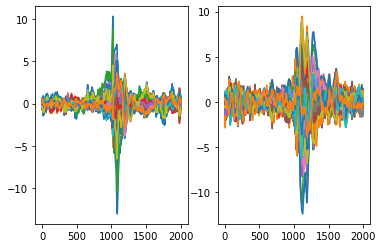

In [7]:

fig, ax = plt.subplots(1,2)
ax[0].plot(data_high['only_high_trial'][0].T)
ax[1].plot(data_high['only_high_trial'][6].T)
plt.show()

In [8]:
sc_df = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc_df.values
dist_df = pd.read_csv(dist_file, header=None, sep=' ')
dist = dist_df.values

In [9]:
sc = 0.5*(sc+sc.T)
sc =np.log1p(sc)/np.linalg.norm(np.log1p(sc))

In [10]:
stim_weights_file = files_dir + '/stim_weights.npy'
stim_weights = np.load(stim_weights_file)

In [11]:
ki0 =stim_weights[:,np.newaxis]

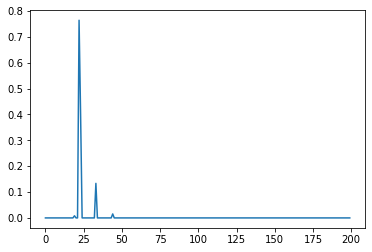

In [12]:
plt.plot(ki0)

Please download the individual leadfield matrix at: 

https://drive.google.com/drive/folders/11jOvrzupbm2W8QdKTa9gPeG2Ivk4BdMN?usp=sharing

and replate the path in the cell below: 

file_leadfield = path/to/your/leadfield_from_mne

sub:  0
epoch:  0 -3188.8367
epoch:  0 0.43244531568492395 cos_sim:  0.11795605650525359
epoch:  1 -6393.2554
epoch:  1 0.411749272623987 cos_sim:  0.03001698942862926
epoch:  2 -9189.017
epoch:  2 0.39830660563879383 cos_sim:  0.04837571256815108
epoch:  3 -11011.923
epoch:  3 0.4111763859185578 cos_sim:  0.057726650653889
epoch:  4 -12701.181
epoch:  4 0.42425572973486103 cos_sim:  0.0742314762046428
epoch:  5 -13974.889
epoch:  5 0.44714909085039106 cos_sim:  0.09243297368687242
epoch:  6 -15065.895
epoch:  6 0.4747003645013756 cos_sim:  0.11359817826552863
epoch:  7 -16031.479
epoch:  7 0.5212858656261586 cos_sim:  0.13367196691976446
epoch:  8 -16889.098
epoch:  8 0.5612241938489739 cos_sim:  0.15368831770527921
epoch:  9 -17660.756
epoch:  9 0.5976144726470293 cos_sim:  0.1774267074828247
epoch:  10 -18364.092
epoch:  10 0.6266809294224387 cos_sim:  0.2005184513441831
epoch:  11 -19011.672
epoch:  11 0.6416063242525543 cos_sim:  0.2256408292528069
epoch:  12 -19612.305
epoch:  12

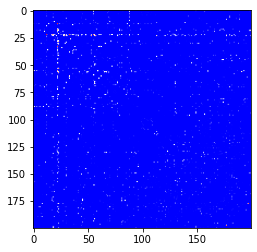

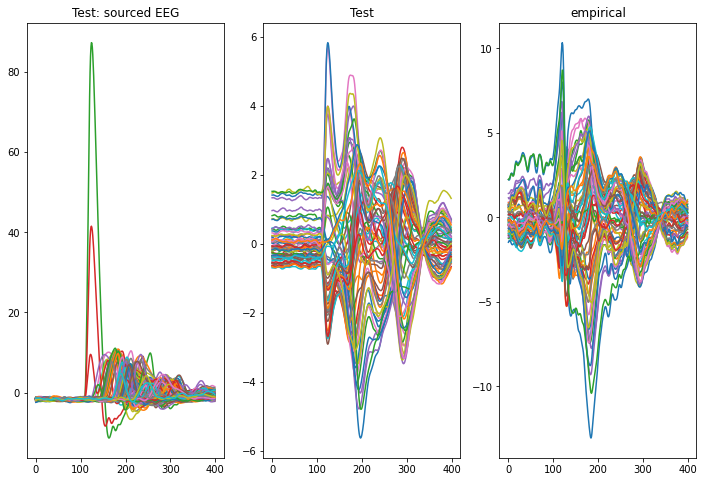

running time is  1521.3761403560638 's


In [ ]:
start_time = time.time()
node_size = stim_weights.shape[0]
output_size = gm.shape[0]
batch_size = 50
step_size = 0.0001
input_size = 3
num_epoches = 120
tr = 0.001
state_size =6
base_batch_num = 20

lm_v = np.zeros((output_size,node_size))

#['gm']:#[0, 1,2,3,5,6,7,8,9,10, 12,13,14,15,16,17,18]:#
#for i in range(data_high['only_high_trial'].shape[0]):
for i in range(1):
    print('sub: ', i)
    data_mean = [data_high['only_high_trial'][i]]*num_epoches
    #data_mean = [gm]*num_epoches
    data_mean =np.array(data_mean)
    file_leadfield = '/content/drive/MyDrive/reproduce_Momi_et_al_2022/data/leadfield_from_mne/sub'+ str(i+1).zfill(3)+'/leadfield.npy'
    lm = np.load(file_leadfield, allow_pickle=True)

    par = ParamsJR('JR', A = [3.25, 0], a= [100, 0.5], B = [22, 0], b = [50, 1], g=[1000, .1], \
                    c1 = [135, 0.2], c2 = [135*0.8, 0.4], c3 = [135*0.25, 0.8], c4 = [135*0.25, 0.8],\
                    std_in=[100, 10], vmax= [5, 0], v0=[6,0], r=[0.56, 0], y0=[2 * np.ones((output_size, 1)), 2 * np.ones((output_size, 1))],\
                    mu = [1., 2.5], k = [10, .3], cy0 = [5, 0], ki=[ki0, 0], lm=[lm, 1.0 * np.ones((output_size, node_size))+lm_v]
                   ,w_bb=[sc, 50 * np.ones((node_size, node_size))])
    
    model = RNNJANSEN(input_size, node_size, batch_size, step_size, output_size, tr, sc, lm, dist, True, False, par)

    # call model fit method
    F = Model_fitting(model, data_mean[:,:,900:1300], num_epoches, 0)

    # fit data(train)
    u = np.zeros((node_size,10,400))
    u[:,:,110:120]= 1000
    output_train = F.train(u=u)
    
    u = np.zeros((node_size,10,400))
    u[:,:,110:120]= 1000
    X0 = np.random.uniform(0, 5, (node_size, state_size))
    hE0 = np.random.uniform(0, 5, (node_size, 500))
    
    output_test = F.test(X0, hE0, base_batch_num, u=u)

    sc_mod = np.zeros((200,200))
    mask = np.tril_indices(200,-1)


    sc_mod[mask] = F.output_sim.weights[-10:,:].mean(0)
    sc_mod = sc_mod+sc_mod.T 
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    ax.imshow(np.log1p(sc_mod), cmap = 'bwr')
    plt.show()

    filename = '/content/drive/MyDrive/EEG/reproduce_fig/sub_'+str(i)+'_fittingresults_stim_exp.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(F, f) 
    
    outfilename = '/content/drive/MyDrive/EEG/reproduce_fig/sub_'+str(i)+'_simEEG_stim_exp.pkl'
    

    with open(outfilename, 'wb') as f:
        pickle.dump(F.output_sim, f)
    
    fig, ax = plt.subplots(1,3, figsize=(12,8))
    ax[0].plot((F.output_sim.E_test-F.output_sim.I_test).T)
    ax[0].set_title('Test: sourced EEG')
    ax[1].plot(F.output_sim.eeg_test.T)
    ax[1].set_title('Test')
    ax[2].plot(data_high['only_high_trial'][i].T[900:1300,:])
    ax[2].set_title('empirical')
    plt.show()
end_time =  time.time()
print('running time is  {0} \'s'.format(end_time - start_time ))

In [ ]:
files_dir =  '/external/rprshnas01/netdata_kcni/jglab/Data/Davide/reproduce_Momi_et_al_2022/PyTepFit/data'

pck_files = sorted(glob.glob(files_dir + '/*_fittingresults_stim_exp.pkl'))
pck_files.pop()
pck_files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

In [ ]:
sbj = 0 

with open(pck_files[sbj], 'rb') as f:
    data = pickle.load(f)


In [ ]:
scipy(F.output_sim.eeg_test, data.output_sim.eeg_test)

(800, 800)

In [ ]:
np.diag(cosine_similarity(F.output_sim.eeg_test, data.output_sim.eeg_test)).mean()

0.9845252

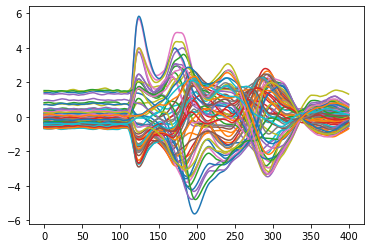

In [ ]:
plt.plot(F.output_sim.eeg_test.T);

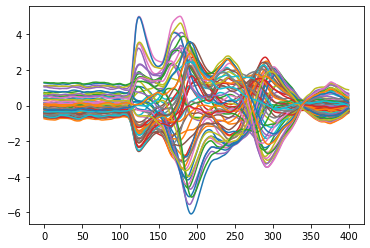

In [ ]:
plt.plot(data.output_sim.eeg_test.T);